PSNR =  29.888663639199955
(288, 352)
PSNR =  16.809713545289235
PSNR =  29.863240424906618


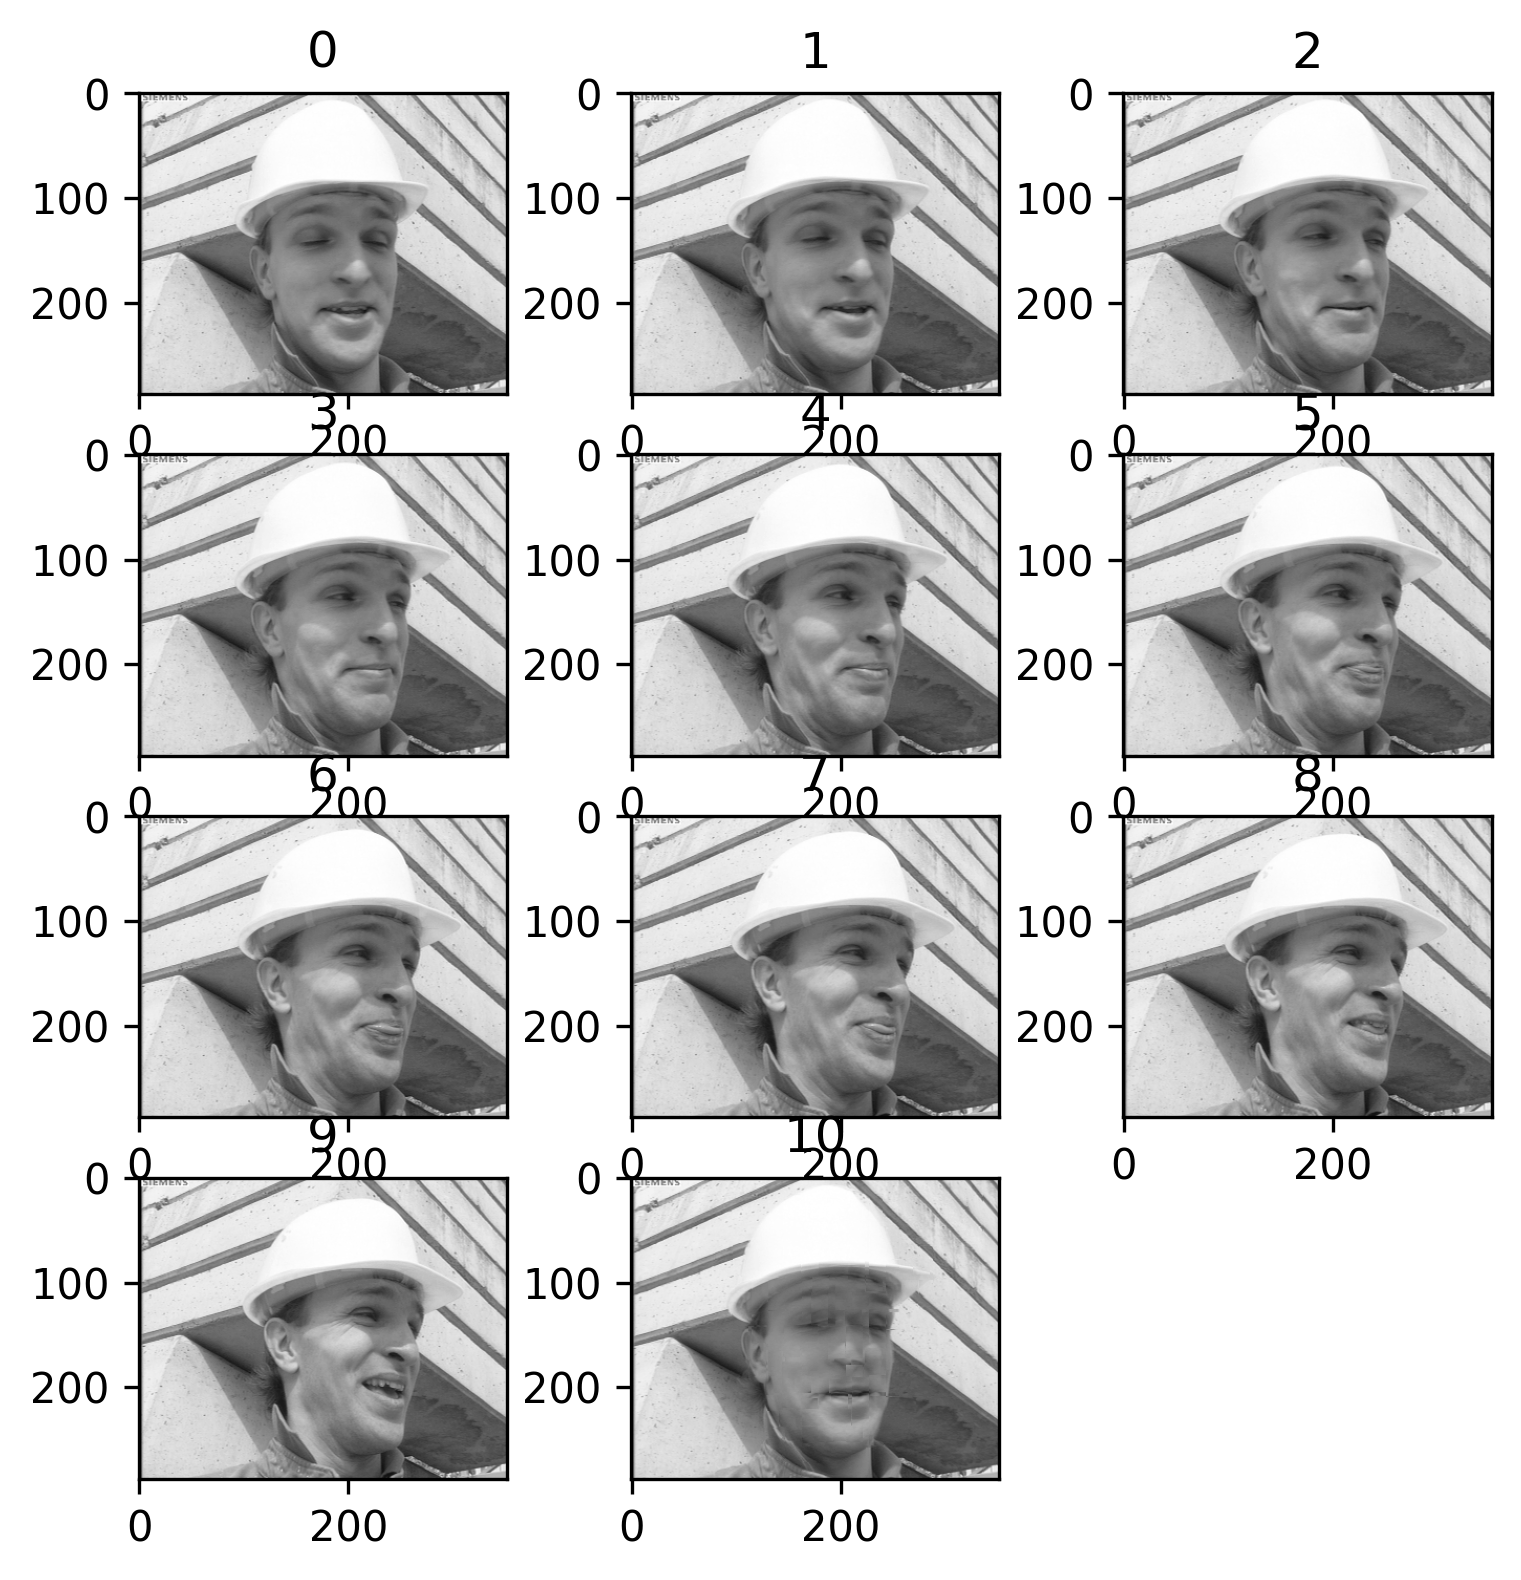

In [1]:
# %% [markdown]
# - Đọc vào 1 chuỗi video
# - Drop frame lẻ
# - Interpolate ra frame lẻ
# - So sánh bằng psnr

# %%
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def loadFrame(videoPath: str, numberFrame: int) -> list:
    frameList = []
    remainFrame = numberFrame
    videoCap = cv.VideoCapture(videoPath)
    success, frame = videoCap.read()
    while success and remainFrame > 0:
        success, frame = videoCap.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frameList.append(frame)
        remainFrame -= 1
    return frameList
###### show ảnh theo grid
plt.figure(figsize=(6.0, 6.0), dpi=300)
plt_row = 4
plt_col = 3
def show(slot, img, title, cmap=None):
    plt.subplot(plt_row, plt_col, slot)
    if cmap is None:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)

# %%
frms = loadFrame('foreman_cif.y4m', 12)
for t in range (0, 11):
    show(t+1, frms[t], t, 'gray')

# %%
### Frame averaging

backward = frms[0].copy()
ground   = frms[1].copy()
forward  = frms[2].copy()

average = backward//2 + forward//2
psnr = cv.PSNR(ground, average)
plt.imshow(average, 'gray')
print('PSNR = ', psnr)

# %%
# Frame compensation
BLOCK_SIZE   = 16
SEARCH_RANGE = 8
SEARCH_STEP  = 1   #ALWAYS :V

backward = frms[0].copy()
ground   = frms[1].copy()
forward  = frms[2].copy()
middle   = np.zeros(ground.shape, np.uint8)

def ABS_subtract(b1, b2):
    if (b1 >= b2):
        return b1 - b2
    return b2 - b1

def get_padding(d):
    bd = 0
    while (bd < d):
        bd += BLOCK_SIZE
    return (bd - d)//2

def MSE(b1, b2):
    sum = 0
    for y in range(0, BLOCK_SIZE):
        for x in range(0, BLOCK_SIZE):
           sum += ABS_subtract(b1[y,x],b2[y,x])**2
    return (sum / (BLOCK_SIZE**2))

def draw_arrow(image, start, end):
    return cv.arrowedLine(image, start, end, (255, 255, 255), 1)

print(middle.shape)
(height, width) = middle.shape
temp = middle.copy()

for y1 in range(0, height, BLOCK_SIZE):
    for x1 in range(0, width, BLOCK_SIZE):
        b1 = backward[y1:y1 + BLOCK_SIZE, x1:x1 + BLOCK_SIZE]
        mm = [(999999, 999999, x1, y1)]
        for y2 in range(y1 - SEARCH_RANGE, y1 + SEARCH_RANGE + BLOCK_SIZE, SEARCH_STEP):
            for x2 in range(x1 - SEARCH_RANGE, x1 + SEARCH_RANGE + BLOCK_SIZE, SEARCH_STEP):
                d = (x2-x1)**2 + (y2-y1)**2
                if(d < SEARCH_RANGE**2):
                    b2 = forward[y2:y2 + BLOCK_SIZE, x2:x2 + BLOCK_SIZE]
                    if (b2.size == BLOCK_SIZE**2):
                        criteria = MSE(b1, b2)
                        mm.append((criteria, d, x2, y2))
        mm = sorted(mm, key=lambda x: (x[0], x[1]))
        (c, d, x, y) = mm[0]
        xm = x1//2 + x//2
        ym = y1//2 + y//2
        middle[ym:ym + BLOCK_SIZE, xm:xm + BLOCK_SIZE] = backward[y1:y1 + BLOCK_SIZE, x1:x1 + BLOCK_SIZE]//2 + forward[y:y + BLOCK_SIZE, x:x + BLOCK_SIZE]//2
        temp = draw_arrow(temp, (x1, y1), (x, y))

plt.imshow(middle, 'gray')
psnr = cv.PSNR(ground, middle)

print('PSNR = ', psnr)

# %%
#Hole retriever
for y in range(0, height):
    for x in range(0, width):
        if (middle[y, x] == 0):
            middle[y, x] = backward [y, x]//2 + forward[y, x]//2
             

plt.imshow(middle, 'gray')
psnr = cv.PSNR(ground, middle)

print('PSNR = ', psnr)